In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from bisect import bisect_left


From the supplement of the Kuzmin et al 2020 paper: "The scoring of 537,911 double and 256,861 triple mutants identified 4,650 negative and 2,547 positive digenic interactions and 2,466 negative and 2,091 positive trigenic interactions."

In [2]:
kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
kuzmin_2020_s1 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S1.txt", sep="\t")
kuzmin_2020_s2 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S2.txt", sep="\t")
kuzmin_2020_s3 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S3.txt", sep="\t")
kuzmin_2020_s5 = pd.read_csv(f"{kuzmin_2020_data_dir}/aaz5667-Table-S5.txt", sep="\t")


kuzmin_2020_s1 = kuzmin_2020_s1.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Raw genetic interaction score (epsilon)": "raw_interaction_score_epsilon",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Query single/double mutant fitness": "query_single_double_mutant_fitness",
                        "Array single mutant fitness": "array_single_mutant_fitness",
                        "Double/triple mutant fitness": "double_triple_mutant_fitness",
                        "Double/triple mutant fitness standard deviation": "double_triple_mutant_fitness_std"})
kuzmin_2020_s2 = kuzmin_2020_s2.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Digenic, Modified trigenic, or Novel trigenic": "digenic_modifiedTrigenic_novelTrigenic"})
# note on s3: query allele fitness for digenic crosses are all NaN, only array allele fitness available
kuzmin_2020_s3 = kuzmin_2020_s3.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Raw genetic interaction score (epsilon)": "raw_interaction_score_epsilon",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Query single/double mutant fitness": "query_single_double_mutant_fitness",
                        "Array single mutant fitness": "array_single_mutant_fitness",
                        "Double/triple mutant fitness": "double_triple_mutant_fitness",
                        "Double/triple mutant fitness standard deviation": "double_triple_mutant_fitness_std"})

# split the digenic query allele into 2 columns
kuzmin_2020_s1.query_allele_name = kuzmin_2020_s1.query_allele_name.str.replace("_","")
kuzmin_2020_s1.array_allele_name = kuzmin_2020_s1.array_allele_name.str.replace("_","")

kuzmin_2020_s1[['query1_allele_name', 'query2_allele_name']] = kuzmin_2020_s1.query_allele_name.str.split("+", expand=True)
kuzmin_2020_s1['alleles'] = kuzmin_2020_s1[['query1_allele_name', 'query2_allele_name', 'array_allele_name']].agg(','.join, axis=1)

kuzmin_2020_s1_trigenic = kuzmin_2020_s1[kuzmin_2020_s1.combined_mutant_type == 'trigenic'].drop(columns=['combined_mutant_type'])
kuzmin_2020_s1_trigenic = kuzmin_2020_s1_trigenic.reset_index(drop=True)

kuzmin_2020_s1_digenic = kuzmin_2020_s1[kuzmin_2020_s1.combined_mutant_type == 'digenic'].drop(columns=['combined_mutant_type'])
# ho will either be the 1st or second query allele, never the array allele
kuzmin_2020_s1_digenic.alleles = kuzmin_2020_s1_digenic.alleles.str.replace("ho,","")
kuzmin_2020_s1_digenic = kuzmin_2020_s1_digenic.reset_index(drop=True)

kuzmin_2020_s3.query_allele_name = kuzmin_2020_s3.query_allele_name.str.replace("_","")
kuzmin_2020_s3.array_allele_name = kuzmin_2020_s3.array_allele_name.str.replace("_","")

# note on s3: query allele fitness for digenic crosses are all NaN, only array allele fitness available
kuzmin_2020_s3_digenic = kuzmin_2020_s3[kuzmin_2020_s3.combined_mutant_type == "digenic"]
kuzmin_2020_s3_singMutFit = dict(zip(kuzmin_2020_s3.array_allele_name, kuzmin_2020_s3.array_single_mutant_fitness))





# S5 table with single and double mutant fitnesses
kuzmin_2020_s5 = kuzmin_2020_s5.rename(columns = {"Allele1" : "allele1",
                                            "Allele2" : "allele2",
                                            "Mutant type" : "mutant_type",
                                            "Fitness" : "fitness",
                                            "St.dev." : "std"})
kuzmin_2020_s5.allele1 = kuzmin_2020_s5.allele1.str.replace("_","")
kuzmin_2020_s5.allele2 = kuzmin_2020_s5.allele2.str.replace("_","")
kuzmin_2020_s5['alleles'] = kuzmin_2020_s5[['allele1', 'allele2']].agg(','.join, axis=1)
kuzmin_2020_s5.alleles = kuzmin_2020_s5.alleles.str.replace("ho,","")
kuzmin_2020_s5.alleles = kuzmin_2020_s5.alleles.str.replace("ho","")

kuzmin_2020_s5_dblMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Double mutant"]
kuzmin_2020_s5_dblMutFit = dict(zip(kuzmin_2020_s5_dblMut.alleles, kuzmin_2020_s5_dblMut.fitness))
kuzmin_2020_s5_singMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Single mutant"]
kuzmin_2020_s5_singMutFit = dict(zip(kuzmin_2020_s5_singMut.alleles, kuzmin_2020_s5_singMut.fitness))


# repeat for table s2
kuzmin_2020_s2[['query1_allele_name', 'query2_allele_name']] = kuzmin_2020_s2.query_allele_name.str.split("+", expand=True)
kuzmin_2020_s2['three_alleles'] = kuzmin_2020_s2[['query1_allele_name', 'query2_allele_name', 'array_allele_name']].agg(','.join, axis=1)
kuzmin_2020_s2.three_alleles = kuzmin_2020_s2.three_alleles.str.replace("_","")
#kuzmin_2020_s2

kuzmin_2020_s1_dblMutFit = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.double_triple_mutant_fitness))
kuzmin_2020_s1_epsilon = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.raw_interaction_score_epsilon))
kuzmin_2020_s1_singMutFit = dict(zip(kuzmin_2020_s1.array_allele_name, kuzmin_2020_s1.array_single_mutant_fitness))

print(kuzmin_2020_s1.combined_mutant_type.value_counts())
print(kuzmin_2020_s2.combined_mutant_type.value_counts())
print("summing total digenic from Kuzmin 2020:", 4650+2547)
print("summing total trigenic from Kuzmin 2020:", 2466+2091)


digenic     537911
trigenic    256861
Name: combined_mutant_type, dtype: int64
digenic     7197
trigenic    4557
Name: combined_mutant_type, dtype: int64
summing total digenic from Kuzmin 2020: 7197
summing total trigenic from Kuzmin 2020: 4557


In [3]:
tmp = kuzmin_2020_s3[kuzmin_2020_s3.combined_mutant_type == "digenic"]
#tmp
#tmp.array_single_mutant_fitness.unique()

In [4]:
print(len(kuzmin_2020_s1_digenic))
print(len(kuzmin_2020_s1_digenic.alleles.unique()))

537911
537911


In [5]:
kuzmin_et_al_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2018/data_files"
kuzmin_2018_s1 = pd.read_csv(f"{kuzmin_et_al_data_dir}/Data File S1_Raw genetic interaction dataset.tsv", sep="\t")
kuzmin_s2 = pd.read_csv(f"{kuzmin_et_al_data_dir}/Data File S2_Digenic and adjusted trigenic interaction dataset OpenedExportedFromExcel.txt", sep="\t")

kuzmin_2018_s1 = kuzmin_2018_s1.rename(columns = {"Query strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Combined mutant type": "combined_mutant_type",
                        "Raw genetic interaction score (epsilon)": "raw_interaction_score_epsilon",
                        "Adjusted genetic interaction score (epsilon or tau)": "adjusted_interaction_score_epsilon_or_tau",
                        "P-value": "pval",
                        "Query single/double mutant fitness": "query_single_double_mutant_fitness",
                        "Array single mutant fitness": "array_single_mutant_fitness",
                        "Combined mutant fitness": "combined_mutant_fitness",
                        "Combined mutant fitness standard deviation": "combined_mutant_fitness_std"})

kuzmin_2018_s1 = kuzmin_2018_s1[["query_allele_name", 
                        "array_allele_name", 
                        "combined_mutant_type", 
                        "raw_interaction_score_epsilon", 
                        "adjusted_interaction_score_epsilon_or_tau", 
                        "pval", 
                        "query_single_double_mutant_fitness", 
                        "array_single_mutant_fitness", 
                        "combined_mutant_fitness"]]


kuzmin_2018_s1.query_allele_name = kuzmin_2018_s1.query_allele_name.str.replace("Δ","")
kuzmin_2018_s1.array_allele_name = kuzmin_2018_s1.array_allele_name.str.replace("Δ","")

kuzmin_2018_s1[['query1_allele_name', 'query2_allele_name']] = kuzmin_2018_s1.query_allele_name.str.split("+", expand=True)
kuzmin_2018_s1['alleles'] = kuzmin_2018_s1[['query1_allele_name', 'query2_allele_name', 'array_allele_name']].agg(','.join, axis=1)

kuzmin_2018_s1_trigenic = kuzmin_2018_s1[kuzmin_2018_s1.combined_mutant_type == 'trigenic'].drop(columns=['combined_mutant_type'])
kuzmin_2018_s1_trigenic = kuzmin_2018_s1_trigenic.reset_index(drop=True)

kuzmin_2018_s1_digenic = kuzmin_2018_s1[kuzmin_2018_s1.combined_mutant_type == 'digenic'].drop(columns=['combined_mutant_type'])
# ho will either be the 1st or second query allele, never the array allele
kuzmin_2018_s1_digenic.alleles = kuzmin_2018_s1_digenic.alleles.str.replace("ho,","")
kuzmin_2018_s1_digenic = kuzmin_2018_s1_digenic.reset_index(drop=True)

#dict(zip(kuzmin_2018_s1_digenic.array_allele_name, kuzmin_2018_s1_digenic.array_single_mutant_fitness))

kuzmin_2018_s1_digenic.query_allele_name = kuzmin_2018_s1_digenic.query_allele_name.str.replace("\+ho","")
kuzmin_2018_s1_digenic.query_allele_name = kuzmin_2018_s1_digenic.query_allele_name.str.replace("ho\+","")

kuzmin_2018_singMutFit = dict(zip(pd.concat([kuzmin_2018_s1.array_allele_name, kuzmin_2018_s1_digenic.query_allele_name], axis=0), 
                            pd.concat([kuzmin_2018_s1.array_single_mutant_fitness, kuzmin_2018_s1_digenic.query_single_double_mutant_fitness], axis=0)
))
kuzmin_2018_dblMutFit = dict(zip(kuzmin_2018_s1_digenic.alleles, kuzmin_2018_s1_digenic.combined_mutant_fitness))
kuzmin_2018_s1_digenic


,query_allele_name,array_allele_name,raw_interaction_score_epsilon,adjusted_interaction_score_epsilon_or_tau,pval,query_single_double_mutant_fitness,array_single_mutant_fitness,combined_mutant_fitness,query1_allele_name,query2_allele_name,alleles
0,nup60,gem1,-0.008680,-0.008680,0.43950,0.9528,0.8595,0.8103,nup60,ho,"nup60,gem1"
1,nup60,oaf1,-0.012815,-0.012815,0.41940,0.9528,0.9665,0.9081,nup60,ho,"nup60,oaf1"
2,nup60,flc2,-0.045327,-0.045327,0.26650,0.9528,0.9675,0.8765,nup60,ho,"nup60,flc2"
3,nup60,acs1,-0.022210,-0.022210,0.37030,0.9528,0.9875,0.9187,nup60,ho,"nup60,acs1"
4,nup60,pex22,-0.029287,-0.029287,0.33580,0.9528,0.8713,0.8009,nup60,ho,"nup60,pex22"
...,...,...,...,...,...,...,...,...,...,...,...
410394,ski3,sec8-9,-0.069336,-0.069336,0.02908,0.9346,0.9211,0.7915,ski3,ho,"ski3,sec8-9"
410395,ski3,brr1,0.042359,0.042359,0.30760,0.9346,0.7907,0.7813,ski3,ho,"ski3,brr1"
410396,ski3,rox1,-0.010273,-0.010273,0.44220,0.9346,0.9890,0.9140,ski3,ho,"ski3,rox1"
410397,ski3,med1,0.105338,0.105338,0.19500,0.9346,0.7060,0.7651,ski3,ho,"ski3,med1"


In [6]:
costanzo_et_al_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/CostanzoEtAl2016/data_files/Data File S1. Raw genetic interaction datasets: Pair-wise interaction format"

costanzo_nxn = pd.read_csv(f"{costanzo_et_al_data_dir}/SGA_NxN.txt", sep="\t")
costanzo_exn = pd.read_csv(f"{costanzo_et_al_data_dir}/SGA_ExN.txt", sep="\t")
costanzo_exe = pd.read_csv(f"{costanzo_et_al_data_dir}/SGA_ExE.txt", sep="\t")


costanzo_data_column_rename = {"Query Strain ID" : "query_strain_id",
                        "Query allele name": "query_allele_name",
                        "Array Strain ID": "array_strain_id",
                        "Array allele name": "array_allele_name",
                        "Arraytype/Temp" : "Arraytype_Temp",
                        "Genetic interaction score (ε)" : "genetic_interaction_e",
                        "P-value": "pval",
                        "Query single mutant fitness (SMF)": "query_smf",
                        "Array SMF": "array_smf",
                        "Double mutant fitness": "dbl_mutant_fitness",
                        "Double mutant fitness standard deviation": "dbl_mutant_fitness_std"}

costanzo_nxn = costanzo_nxn.rename(columns = costanzo_data_column_rename)
costanzo_exn = costanzo_exn.rename(columns = costanzo_data_column_rename)
costanzo_exe = costanzo_exe.rename(columns = costanzo_data_column_rename)
costanzo = pd.concat([costanzo_nxn, costanzo_exn, costanzo_exe])

costanzo = costanzo.astype({'query_strain_id': 'str',
                    'query_allele_name': 'str',
                    'array_strain_id': 'str',
                    'array_allele_name': 'str',
                    'Arraytype_Temp': 'str'})

costanzo = costanzo[['query_allele_name', 'array_allele_name', 'query_smf', 'array_smf', 'dbl_mutant_fitness']]
# this solution is really fast
costanzo['alleles'] = [a + "," + b for a,b in zip(costanzo.query_allele_name, costanzo.array_allele_name)]


costanzo = costanzo.reset_index(drop=True)
#costanzo.head()

costanzo_singMutFit = dict(zip(
                        list(pd.concat([costanzo.query_allele_name, costanzo.array_allele_name], axis=0)),
                        list(pd.concat([costanzo.query_smf, costanzo.array_smf], axis=0))
                        ))
costanzo_dblMutFit = dict(zip(costanzo.alleles, costanzo.dbl_mutant_fitness))

**From the main text**:

Using colony size as a proxy for cell fitness, we measured the growth pheno- types of the set of 240 double-mutant query strains and the corresponding 480 single mu- tants (table S5) (42), which correlated well with previous large-scale measurements of single-mutant fitness (Pearson correlation co- efficient r =0.51, P =3×10−30)

**From the supplement**:

The mean single mutant fitness estimates of each array strain were obtained from a previous study (37).

**Conclusion**:

Double mutants:

- take ij mutants from Kuzmin 2020 S5

- take ik and jk mutants from Kuzmin 2020 S1

Single mutants:

- take i from Kuzmin 2020 S3?????

- take j from Kuzmin 2020 S5

- take k from Kuzmin 2020 S1


In [7]:
def bi_contains(lst, item):
    """ efficient `item in lst` for sorted lists """
    # if item is larger than the last its not in the list, but the bisect would 
    # find `len(lst)` as the index to insert, so check that first. Else, if the 
    # item is in the list then it has to be at index bisect_left(lst, item)
    return (item <= lst[-1]) and (lst[bisect_left(lst, item)] == item)

sort_alleles = sorted(list(kuzmin_2020_s1_digenic.alleles))
sort_alleles2 = sorted(list(kuzmin_2018_s1_digenic.alleles))
sort_alleles3 = sorted(list(costanzo_dblMutFit.keys()))
sort_alleles4 = sorted(list(costanzo_singMutFit.keys()))
sort_alleles5 = sorted(list(kuzmin_2020_s1_singMutFit.keys()))
sort_alleles6 = sorted(list(kuzmin_2020_s1_epsilon.keys()))

sort_alleles7 = sorted(list(kuzmin_2020_s5_dblMutFit.keys()))
sort_alleles8 = sorted(list(kuzmin_2020_s5_singMutFit.keys()))
sort_alleles9 = sorted(list(kuzmin_2018_s1.array_allele_name))
sort_alleles10 = sorted(list(kuzmin_2020_s3_singMutFit.keys()))


i_inKuzmin2020_s1_or_s3 = 0

i_inCostanzo = 0
j_inCostanzo = 0
k_inCostanzo = 0

i_inKuzmin2020_s3 = 0
j_inKuzmin2020_s3 = 0
k_inKuzmin2020_s3 = 0

i_inKuzmin2020_s5 = 0
j_inKuzmin2020_s5 = 0
k_inKuzmin2020_s5 = 0

i_inKuzmin2020_s1 = 0
j_inKuzmin2020_s1 = 0
k_inKuzmin2020_s1 = 0

i_inKuzmin2018_s1 = 0
j_inKuzmin2018_s1 = 0
k_inKuzmin2018_s1 = 0

ik_inKuzmin2020_s5 = 0
jk_inKuzmin2020_s5 = 0
ij_inKuzmin2020_s5 = 0

ik_inKuzmin2020_s1 = 0
jk_inKuzmin2020_s1 = 0
ij_inKuzmin2020_s1 = 0


for i, row in kuzmin_2020_s1_trigenic.iterrows():
    #if i <= 100:
        alleles = row['alleles'].split(",")
        ij = alleles[0] + "," + alleles[1]
        ji = alleles[1] + "," + alleles[0]

        ik = alleles[0] + "," + alleles[2]
        ki = alleles[2] + "," + alleles[0]

        jk = alleles[1] + "," + alleles[2]
        kj = alleles[2] + "," + alleles[1]

        i,j,k = alleles[0], alleles[1], alleles[2]
        # check if double mutant fitnesses exist
        # are ik and jk in kuzmin_2020_21
        if bi_contains(sort_alleles7, ik) or bi_contains(sort_alleles7, ki):
            ik_inKuzmin2020_s5 += 1
        if bi_contains(sort_alleles7, jk) or bi_contains(sort_alleles7, kj):
            jk_inKuzmin2020_s5 += 1            
        if bi_contains(sort_alleles7, ij) or bi_contains(sort_alleles7, ji):
            ij_inKuzmin2020_s5 += 1        

        if bi_contains(sort_alleles, ik) or bi_contains(sort_alleles, ki):
            ik_inKuzmin2020_s1 += 1
        if bi_contains(sort_alleles, jk) or bi_contains(sort_alleles, kj):
            jk_inKuzmin2020_s1 += 1            
        if bi_contains(sort_alleles, ij) or bi_contains(sort_alleles, ji):
            ij_inKuzmin2020_s1 += 1       

        if bi_contains(sort_alleles5, i):
            i_inKuzmin2020_s1 += 1  
        if bi_contains(sort_alleles5, j):
            j_inKuzmin2020_s1 += 1  
        if bi_contains(sort_alleles5, k):
            k_inKuzmin2020_s1 += 1    

        if bi_contains(sort_alleles8, i):
            i_inKuzmin2020_s5 += 1  
        if bi_contains(sort_alleles8, j):
            j_inKuzmin2020_s5 += 1  
        if bi_contains(sort_alleles8, k):
            k_inKuzmin2020_s5 += 1         
        
        if bi_contains(sort_alleles10, i):
            i_inKuzmin2020_s3 += 1  
        if bi_contains(sort_alleles10, j):
            j_inKuzmin2020_s3 += 1  
        if bi_contains(sort_alleles10, k):
            k_inKuzmin2020_s3 += 1      

        if bi_contains(sort_alleles5, i) or bi_contains(sort_alleles10, i):
            i_inKuzmin2020_s1_or_s3 +=1

        if bi_contains(sort_alleles9, i):
            i_inKuzmin2018_s1 += 1  
        if bi_contains(sort_alleles9, j):
            j_inKuzmin2018_s1 += 1  
        if bi_contains(sort_alleles9, k):
            k_inKuzmin2018_s1 += 1       

        if bi_contains(sort_alleles4, i):
            i_inCostanzo += 1
        if bi_contains(sort_alleles4, j):
            j_inCostanzo += 1
        if bi_contains(sort_alleles4, k):
            k_inCostanzo += 1



print("There are 256,861 triple mutants, so we need this many values for double and single mutants")
print("DOUBLE MUTANTS")
print("ik_inKuzmin2020_s5", ik_inKuzmin2020_s5)
print("jk_inKuzmin2020_s5", jk_inKuzmin2020_s5)
print("  ij_inKuzmin2020_s5", ij_inKuzmin2020_s5)
print("###")
print("  ik_inKuzmin2020_s1", ik_inKuzmin2020_s1)
print("  jk_inKuzmin2020_s1", jk_inKuzmin2020_s1)
print("ij_inKuzmin2020_s1", ij_inKuzmin2020_s1)
print()
print("SINGLE MUTANTS")
print("i_inKuzmin2020_s5", i_inKuzmin2020_s5)
print("  j_inKuzmin2020_s5", j_inKuzmin2020_s5)
print("k_inKuzmin2020_s5", k_inKuzmin2020_s5)
print("###")
print("i_inKuzmin2020_s1", i_inKuzmin2020_s1)
print("j_inKuzmin2020_s1", j_inKuzmin2020_s1)
print("k_inKuzmin2020_s1", k_inKuzmin2020_s1, "  they mentioned taking these values from Kuzmin 2018 s1")
print("###")
print("i_inKuzmin2020_s3", i_inKuzmin2020_s3)
print("j_inKuzmin2020_s3", j_inKuzmin2020_s3)
print("k_inKuzmin2020_s3", k_inKuzmin2020_s3)
print("###")
print("i_inKuzmin2018_s1", i_inKuzmin2018_s1)
print("j_inKuzmin2018_s1", j_inKuzmin2018_s1)
print("  k_inKuzmin2018_s1", k_inKuzmin2018_s1)
print("###")
print("i_inKuzmin2020_s1_or_s3", i_inKuzmin2020_s1_or_s3)
print("###")
print("i_inCostanzo", i_inCostanzo)
print("j_inCostanzo", j_inCostanzo)
print("k_inCostanzo", k_inCostanzo)




There are 256,861 triple mutants, so we need this many values for double and single mutants
DOUBLE MUTANTS
ik_inKuzmin2020_s5 0
jk_inKuzmin2020_s5 0
  ij_inKuzmin2020_s5 256861
###
  ik_inKuzmin2020_s1 256850
  jk_inKuzmin2020_s1 256773
ij_inKuzmin2020_s1 80015

SINGLE MUTANTS
i_inKuzmin2020_s5 0
  j_inKuzmin2020_s5 255804
k_inKuzmin2020_s5 10833
###
i_inKuzmin2020_s1 44740
j_inKuzmin2020_s1 53190
k_inKuzmin2020_s1 256861   they mentioned taking these values from Kuzmin 2018 s1
###
i_inKuzmin2020_s3 226427
j_inKuzmin2020_s3 230724
k_inKuzmin2020_s3 238757
###
i_inKuzmin2018_s1 45744
j_inKuzmin2018_s1 53190
  k_inKuzmin2018_s1 256436
###
i_inKuzmin2020_s1_or_s3 228568
###
i_inCostanzo 245873
j_inCostanzo 248089
k_inCostanzo 241138


Consider three genes i, j, and k. Based on the experimental design of Kuzmin et al, they compute digenic interaction effects between genes i and k (e_ik) and between genes j and k (e_jk). Then, they cross the double mutant ij with single mutant k. This cross introduces 3 interaction effects: 2 digenic (e_ik and e_jk) and 1 trigenic (t_ijk). They compute the trigenic effect by subtracting out the two previously calculated digenic effects. Note that e_ij isn't calculated here and is irrelevant.

For each triple mutant ijk, let's confirm that double mutants ik and jk exist:

In [8]:

f_ij, f_ik, f_jk = defaultdict(), defaultdict(), defaultdict()
f_i, f_j, f_k = defaultdict(), defaultdict(), defaultdict()
e_ik_kuz, e_jk_kuz = defaultdict(), defaultdict()

for i, row in kuzmin_2020_s1_trigenic.iterrows():
    #if i <= 100:
        alleles = row['alleles'].split(",")
        ij = alleles[0] + "," + alleles[1]
        ji = alleles[1] + "," + alleles[0]

        ik = alleles[0] + "," + alleles[2]
        ki = alleles[2] + "," + alleles[0]

        jk = alleles[1] + "," + alleles[2]
        kj = alleles[2] + "," + alleles[1]

        i,j,k = alleles[0], alleles[1], alleles[2]
       
        try:
            f_ij[row['alleles']] = kuzmin_2020_s5_dblMutFit[ij]
        except KeyError:
            f_ij[row['alleles']] = float('nan')
        try:
            f_ik[row['alleles']] = kuzmin_2020_s1_dblMutFit[ik]
        except KeyError:
            f_ik[row['alleles']] = float('nan')
        try:
            f_jk[row['alleles']] = kuzmin_2020_s1_dblMutFit[jk]
        except KeyError:
            f_jk[row['alleles']] = float('nan')
        
        
        # get single mutant fitnesses
        try:
            f_i[row['alleles']] = kuzmin_2020_s3_singMutFit[i]
        except KeyError:
            f_i[row['alleles']] = float('nan')
        try:
            f_j[row['alleles']] = kuzmin_2020_s5_singMutFit[j]
        except KeyError:
            f_j[row['alleles']] = float('nan')  
        try:
            f_k[row['alleles']] = kuzmin_2020_s1_singMutFit[k]
        except KeyError:
            f_k[row['alleles']] = float('nan')      

        """try:
            f_i[row['alleles']] = costanzo_singMutFit[i]
        except KeyError:
            f_i[row['alleles']] = float('nan')
        try:
            f_j[row['alleles']] = costanzo_singMutFit[j]
        except KeyError:
            f_j[row['alleles']] = float('nan')  
        try:
            f_k[row['alleles']] = costanzo_singMutFit[k]
        except KeyError:
            f_k[row['alleles']] = float('nan')"""
       
       # get pairwise epistasis
        try:
            e_ik_kuz[row['alleles']] = kuzmin_2020_s1_epsilon[ik]
        except KeyError:
            e_ik_kuz[row['alleles']] = float('nan')

        try:
            e_jk_kuz[row['alleles']] = kuzmin_2020_s1_epsilon[jk]
        except KeyError:
            e_jk_kuz[row['alleles']] = float('nan')

kuzmin_2020_s1_trigenic['f_ij'] = kuzmin_2020_s1_trigenic['alleles'].map(f_ij)
kuzmin_2020_s1_trigenic['f_ik'] = kuzmin_2020_s1_trigenic['alleles'].map(f_ik)
kuzmin_2020_s1_trigenic['f_jk'] = kuzmin_2020_s1_trigenic['alleles'].map(f_jk)

kuzmin_2020_s1_trigenic['f_i'] = kuzmin_2020_s1_trigenic['alleles'].map(f_i)
kuzmin_2020_s1_trigenic['f_j'] = kuzmin_2020_s1_trigenic['alleles'].map(f_j)
kuzmin_2020_s1_trigenic['f_k'] = kuzmin_2020_s1_trigenic['alleles'].map(f_k)

kuzmin_2020_s1_trigenic['e_ik_kuz'] = kuzmin_2020_s1_trigenic['alleles'].map(e_ik_kuz)
kuzmin_2020_s1_trigenic['e_jk_kuz'] = kuzmin_2020_s1_trigenic['alleles'].map(e_jk_kuz)



In [9]:


print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_ij)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_ik)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_jk)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_i)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_j)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.f_k)))
print()
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.e_ik_kuz)))
print(np.sum(~np.isnan(kuzmin_2020_s1_trigenic.e_jk_kuz)))

#print(len(kuzmin_2020_s1_trigenic.f_ik))
print(len(kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
print(len(kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
print(len(kuzmin_2020_s1_trigenic))
print(len(kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(kuzmin_2020_s1_trigenic))

215617
256850
256773
226427
254763
256861

256850
256773
189340
189340
256861
0.7371301988234882


0.9891940424632936
187294


,tau_kuzmin_orig,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig,1.000000,0.997447
adjusted_interaction_score_epsilon_or_tau,0.997447,1.000000


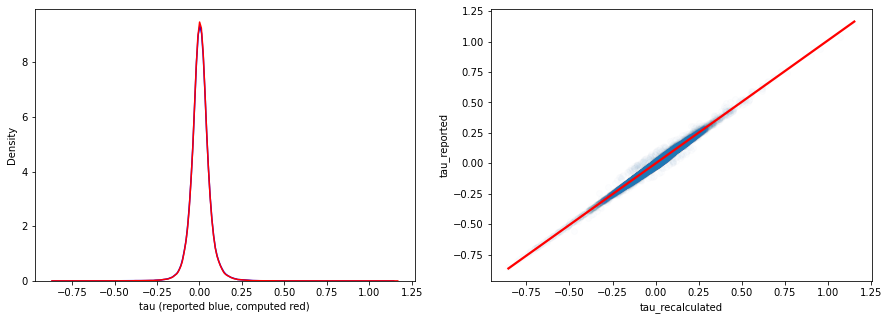

In [10]:

kuzmin_2020_s1_trigenic = kuzmin_2020_s1_trigenic.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])
threshold = 0.1

df = kuzmin_2020_s1_trigenic
df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i
# filter out results that aren't reproducible according to the original equation
print(len(df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold])/len(df))
df = df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold]
print(len(df))

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df['tau_kuzmin_orig'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')

df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")
#kuzmin_2020_s1_trigenic[['tau_kuzmin2', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")
#kuzmin_2020_s1_trigenic[['tau_kuzmin2', 'tau_kuzmin1']].corr(method="pearson")

<ipython-input-11-91d6520ac40e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau_kuzmin_orig2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*(df.f_j*df.f_k + df.e_jk_kuz) - df.f_j*(df.f_i*df.f_k + df.e_ik_kuz) - df.f_k*df.f_ij


,tau_kuzmin_orig2,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig2,1.000000,0.997447
adjusted_interaction_score_epsilon_or_tau,0.997447,1.000000


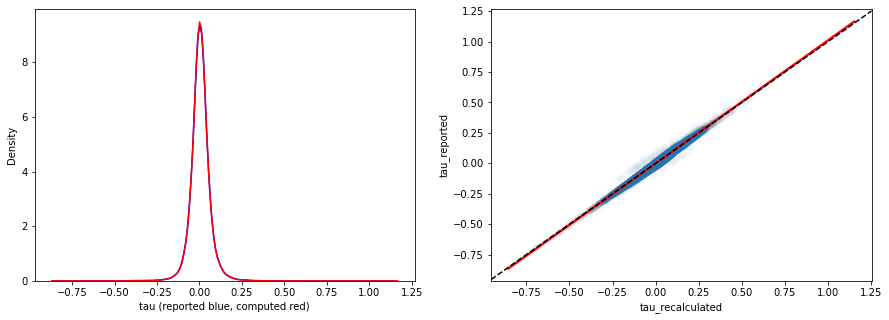

In [11]:
# rearranging their equation into the isserlis formula, not that I only used the variables present in the original formula:
# i,i,k, ij, e_ik, e_jk
# note that f_ik and f_jk are not used
df['tau_kuzmin_orig2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*(df.f_j*df.f_k + df.e_jk_kuz) - df.f_j*(df.f_i*df.f_k + df.e_ik_kuz) - df.f_k*df.f_ij

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig2'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df['tau_kuzmin_orig2'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-0.75, -0.75], [1, 1], linestyle="--", color="black")

df[['tau_kuzmin_orig2', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

<ipython-input-12-13688a5be30b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau_isserlis'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij


,tau_isserlis,adjusted_interaction_score_epsilon_or_tau
tau_isserlis,1.000000,0.639814
adjusted_interaction_score_epsilon_or_tau,0.639814,1.000000


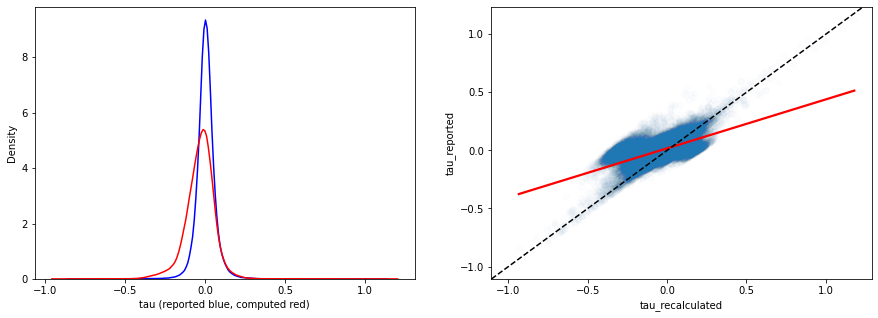

In [12]:
# subsituting in f_jk for (f_j*f_k + e_jk) and f_ik for (f_i*f_k + e_ik)
df['tau_isserlis'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_isserlis'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df['tau_isserlis'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-1, -1], [1, 1], linestyle="--", color="black")

df[['tau_isserlis', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

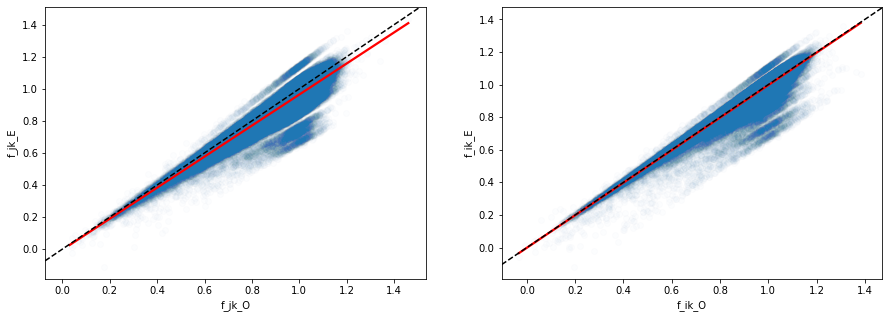

In [13]:
# observed values for double mutants are different from multiplicative independence with epistasis

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.regplot(x=df.f_jk,
            y=(df.f_j*df.f_k + df.e_jk_kuz),
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[0])
p.set(xlabel='f_jk_O', ylabel='f_jk_E')
axs[0].axline([0, 0], [1.4, 1.4], linestyle="--", color="black")

p = sns.regplot(x=df.f_ik,
            y=(df.f_i*df.f_k + df.e_ik_kuz),
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='f_ik_O', ylabel='f_ik_E')
axs[1].axline([0, 0], [1.4, 1.4], linestyle="--", color="black")


#pd.concat([dbl_mut_fit_O, dbl_mut_fit_E], axis=1).corr(method="pearson")

<ipython-input-14-c36e8be9875a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
<ipython-input-14-c36e8be9875a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz
<ipython-input-14-c36e8be9875a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,tau_kuzmin_orig4,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig4,1.000000,0.997447
adjusted_interaction_score_epsilon_or_tau,0.997447,1.000000


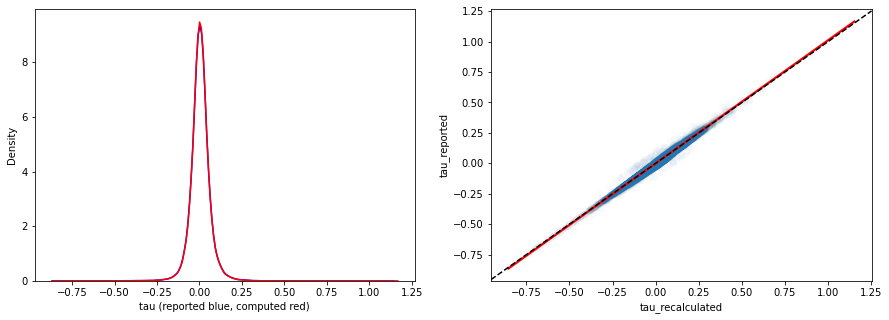

In [14]:
# sunstituting in kuzmin variables

df['f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
df['f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz
df['tau_kuzmin_orig4'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk_2 - df.f_j*df.f_ik_2 - df.f_k*df.f_ij

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig4'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df['tau_kuzmin_orig4'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-0.75,-0.75],[1,1], color="black", linestyle="--")

df[['tau_kuzmin_orig4', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = 

,tau_multiplicative,tau_multiplicative2
tau_multiplicative,1.000000,0.411953
tau_multiplicative2,0.411953,1.000000


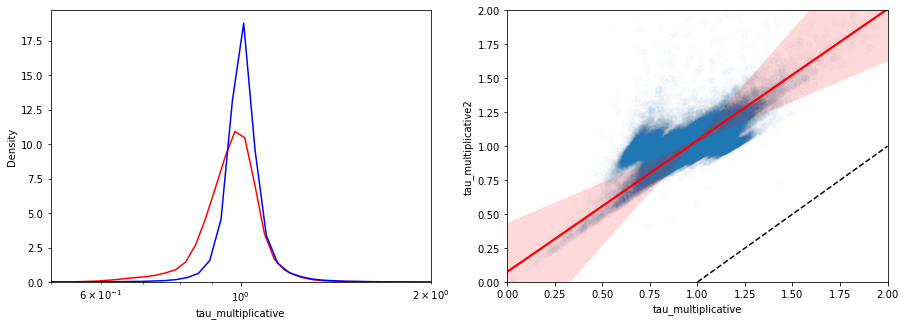

In [15]:
# sunstituting in kuzmin variables
df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)

df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative2'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult2*df.e_jk_mult2) 

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =0.001
p = sns.kdeplot(df['tau_multiplicative'], ax = axs[0], color="red", log_scale=True)
p = sns.kdeplot(df['tau_multiplicative2'], ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.regplot(x=df['tau_multiplicative'],
            y=df['tau_multiplicative2'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_multiplicative', ylabel='tau_multiplicative2')
axs[1].axline([0,-1], [2,1], color="black", linestyle="--")
axs[1].set_xlim(0,2)
axs[1].set_ylim(0,2)

df[['tau_multiplicative', 'tau_multiplicative2']].corr(method="pearson")

/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,tau_multiplicative,tau_multiplicative2
tau_multiplicative,1.000000,0.411953
tau_multiplicative2,0.411953,1.000000


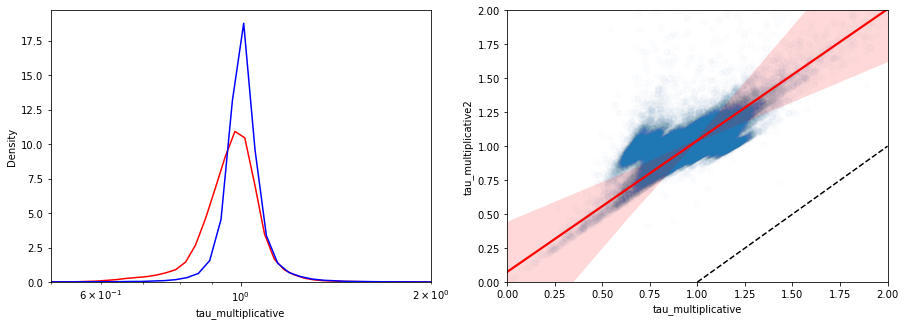

In [16]:
# sunstituting in kuzmin variables
df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)

df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative2'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult2*df.e_jk_mult2) 

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =0.001
p = sns.kdeplot(df['tau_multiplicative'], ax = axs[0], color="red", log_scale=True)
p = sns.kdeplot(df['tau_multiplicative2'], ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.regplot(x=df['tau_multiplicative'],
            y=df['tau_multiplicative2'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_multiplicative', ylabel='tau_multiplicative2')
axs[1].axline([0,-1], [2,1], color="black", linestyle="--")
axs[1].set_xlim(0,2)
axs[1].set_ylim(0,2)

df[['tau_multiplicative', 'tau_multiplicative2']].corr(method="pearson")

/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


                    tau_multiplicative  tau_isserlis
tau_multiplicative            1.000000      0.987936
tau_isserlis                  0.987936      1.000000
                    tau_multiplicative  tau_isserlis
tau_multiplicative             1.00000       0.92651
tau_isserlis                   0.92651       1.00000
                    tau_multiplicative  tau_isserlis
tau_multiplicative            1.000000      0.660153
tau_isserlis                  0.660153      1.000000


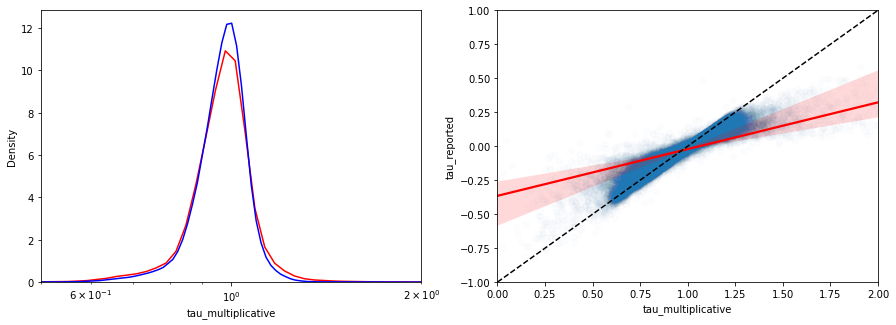

In [17]:
# sunstituting in kuzmin variables
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =0.001
p = sns.kdeplot(df['tau_multiplicative'], ax = axs[0], color="red", log_scale=True)
p = sns.kdeplot(df['tau_isserlis']+1, ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.regplot(x=df['tau_multiplicative'],
            y=df['tau_isserlis'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_multiplicative', ylabel='tau_reported')
axs[1].axline([0,-1], [2,1], color="black", linestyle="--")
axs[1].set_xlim(0,2)
axs[1].set_ylim(-1,1)

print(df[['tau_multiplicative', 'tau_isserlis']].corr(method="spearman"))
print(df[['tau_multiplicative', 'tau_isserlis']].corr(method="kendall"))
print(df[['tau_multiplicative', 'tau_isserlis']].corr(method="pearson"))


In [18]:
print(np.nanmean(df.adjusted_interaction_score_epsilon_or_tau))
print(np.nanmean(df.tau_multiplicative))
print("###")
print(np.nanmedian(df.adjusted_interaction_score_epsilon_or_tau))
print(np.nanmedian(df.tau_multiplicative))
print("###")
print(np.nanstd(df.adjusted_interaction_score_epsilon_or_tau))
print(np.nanstd(df.tau_multiplicative))


0.00447713709996049
0.9699022075451835
###
0.0037835000000000004
0.9741830980175781
###
0.05943114514300463
0.17337197100465504


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.5, 2)

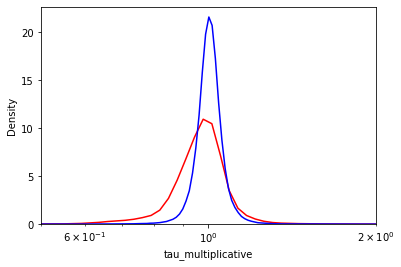

In [19]:
#p = sns.histplot(df['tau_multiplicative'], color="red", log_scale=True)
#p = sns.histplot(df['adjusted_interaction_score_epsilon_or_tau']+1, color="blue")
p = sns.kdeplot(df['tau_multiplicative'], color="red", log_scale=True)
p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau']+1, color="blue")
p.set_xlim(0.5,2)